# 자연어 처리 & 분류 모형 예제
- You are predicting whether a given tweet is about a real disaster or not.
- If so, predict a 1. If not, predict a 0.

## 데이터 불러오기

In [15]:
import sys
print(sys.executable)


C:\Users\User\AppData\Local\Programs\Python\Python311\python.exe


In [1]:
import pandas as pd
DATA_PATH = 'nlp-getting-started/'
train = pd.read_csv(DATA_PATH + 'train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
test = pd.read_csv(DATA_PATH + 'test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 데이터셋 확인

In [3]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

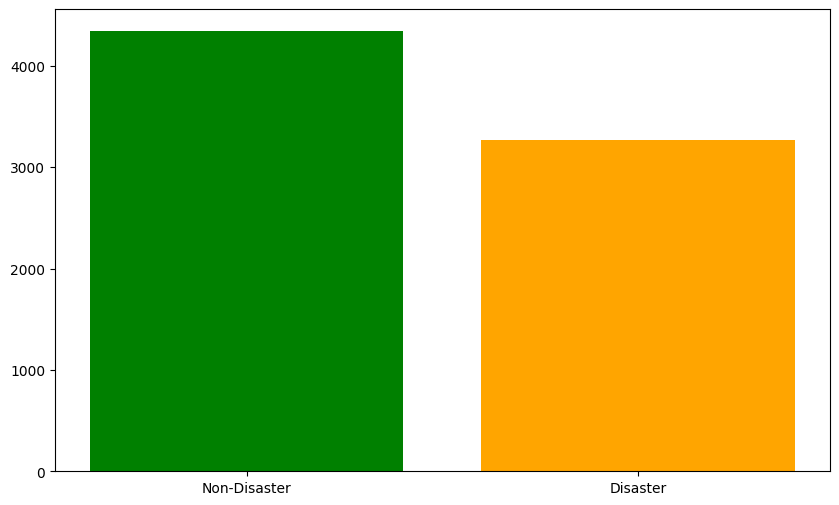

In [7]:
import matplotlib.pyplot as plt
targets = train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(labels, targets, color = ['green', 'orange'])
plt.show()

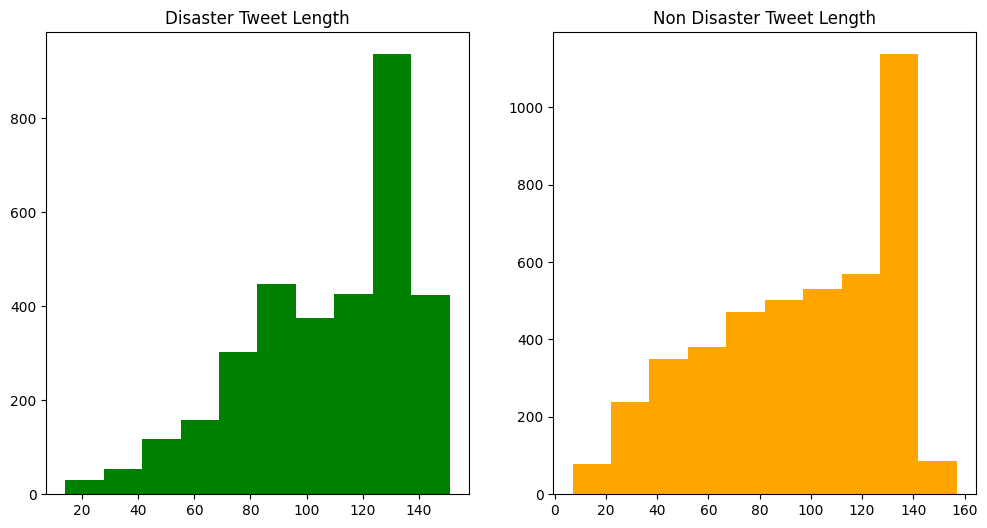

In [8]:
disaster_tweet_len = train[train['target'] == 1 ]['text'].str.len()
non_disaster_tweet_len = train[train['target'] == 0 ]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize= (12, 6))
ax[0].hist(disaster_tweet_len, color = 'green')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color = 'orange')
ax[1].set_title('Non Disaster Tweet Length')
plt.show()

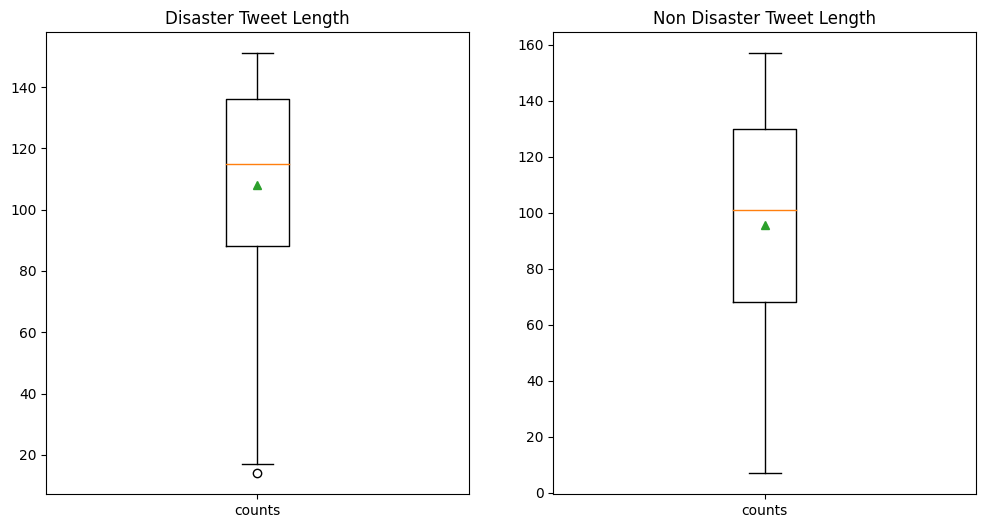

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].boxplot(disaster_tweet_len, labels = ['counts'], showmeans = True)
ax[0].set_title('Disaster Tweet Length')

ax[1].boxplot(non_disaster_tweet_len, labels = ['counts'], showmeans = True)
ax[1].set_title('Non Disaster Tweet Length')

plt.show()

## 워드 클라우드 작성

## 변수 삭제

In [10]:
test_id = test['id']

for df in [train, test]:
    df = df.drop(['id', 'keyword', 'location'], axis = 1, inplace = True)
    
train.shape, test.shape

((7613, 2), (3263, 1))

## 텍스트 데이터 전처리


In [11]:
# url
import re

def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

sample_text = "새로운 캐글 대회가 열렸습니다. 주소: https://www.kaggle.com/c/nlp-getting-started"
remove_url(sample_text)

'새로운 캐글 대회가 열렸습니다. 주소: '

In [12]:
# html 코드 제거
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

sample_text ="""<div>
<h1> Real News or Fake News </h1>
<p> Kaggle Machine Learning </p>
</div>"""

print(remove_html(sample_text))


 Real News or Fake News 
 Kaggle Machine Learning 



In [27]:
#!pip install emoji --upgrade
import sys   
!{sys.executable} -m pip install emoji


  Using cached emoji-2.2.0-py3-none-any.whl


In [28]:
import emoji
print(emoji.emojize('Phd is very easy!!! :thumbs_up:'))

Phd is very easy!!! 👍


In [29]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

remove_emoji("Hello, 👍")

'Hello, '

In [32]:
#!pip install nltk
import sys   
!{sys.executable} -m pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached regex-2023.3.23-cp311-cp311-win_amd64.whl (267 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)


In [33]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print("Total Length of stopwords:", len(stopwords.words('english')))
print(stopwords.words('english')[:10])
# 불용어제거
# I have a dream

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Total Length of stopwords: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [34]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def data_cleansing(text, remove_stopwords = False):
  # remove url 
  url = re.compile(r'https?://\S+|www\.\S+')
  cleaned_text = url.sub(r'', text)

  # remove html
  html = re.compile(r'<.*?>')
  cleaned_text = html.sub(r'', cleaned_text)

  # remove emoji
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  cleaned_text = emoji_pattern.sub(r'', cleaned_text)

  # Special Letters to empty space
  cleaned_text = re.sub("[^a-zA-Z]", " ", cleaned_text)

  # Lowercase
  cleaned_text = cleaned_text.lower().split()

  if remove_stopwords:
    stops = set(stopwords.words("english"))
    cleaned_text = [word for word in cleaned_text if not word in stops]
    clean_review = ' '.join(cleaned_text)
  else:
    clean_review = ' '.join(cleaned_text)

  return clean_review

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
clean_train_reviews = []
for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(lambda x : data_cleansing(x, remove_stopwords=True))

## 텍스트를 숫자로 변환
- 벡터화 (Vectorizer)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
# 말뭉치
corpus = ["As you know, I want to be with you"]
vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)

[[1 1 1 1 1 1 2]]
{'as': 0, 'you': 6, 'know': 2, 'want': 4, 'to': 3, 'be': 1, 'with': 5}


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
corpus = ['Can I have lunch with you?', 
          'No, I cannot have it with you.', 
          'Because, I need to study later']

vector = TfidfVectorizer()
print(np.round(vector.fit_transform(corpus).toarray(), 2))
print(vector.vocabulary_)

[[0.   0.52 0.   0.39 0.   0.   0.52 0.   0.   0.   0.   0.39 0.39]
 [0.   0.   0.46 0.35 0.46 0.   0.   0.   0.46 0.   0.   0.35 0.35]
 [0.45 0.   0.   0.   0.   0.45 0.   0.45 0.   0.45 0.45 0.   0.  ]]
{'can': 1, 'have': 3, 'lunch': 6, 'with': 11, 'you': 12, 'no': 8, 'cannot': 2, 'it': 4, 'because': 0, 'need': 7, 'to': 10, 'study': 9, 'later': 5}


In [38]:
# 데이터 변환
# 데이터셋 분리

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0, 
                             analyzer = 'char', 
                             sublinear_tf = True, 
                             ngram_range = (1,3),
                             max_features = 10000)

X = vectorizer.fit_transform(train['cleaned_text'])
y = train['target'].values
                             

In [39]:
print(X.shape)
print(y.shape)

(7613, 9444)
(7613,)


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.3, random_state = 42
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5329, 9444), (2284, 9444), (5329,), (2284,))

## 모델링

In [42]:
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [43]:
testset = vectorizer.transform(test['cleaned_text'])
print(testset.shape)

(3263, 9444)


In [44]:
y_preds = lgs.predict(testset)
print(y_preds[:5])

[1 1 1 1 1]


In [45]:
submission = pd.DataFrame({'id': test_id, 'target' : y_preds})
submission.to_csv("submission_230329.csv", index = False)